# Product Recommendation Systems

###  George Mathew 

## Objective:
#### To make a recommendation system that recommends at least five(5) new products based on the user's habits.

## Steps and tasks:

1. Read and explore the given dataset.</br>
2. Take a subset of the dataset to make it less sparse/ denser.</br>
3. Split the data randomly into train and test dataset.</br>
4. Build Popularity Recommender model.</br>
5. Build Collaborative Filtering model.</br>
6. Evaluate both the models.</br>
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products.</br>
8. Description of criterion</br>

## Solution:

### 1. Read and explore the given dataset. 

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds  # Singular Value Decomposition

In [2]:
#Import the data into a dataframe
prodData = pd.read_csv("ratings_electronics.csv")

In [3]:
# Add coloumn headers
column_names= ['userId',
               'productId',
               'ratings',
               'timestamp'
               ]
prodData.columns = column_names

In [4]:
# Look at the sample
prodData.head()

,userId,productId,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [5]:
# Drop the timestamp as it is not useful to our objective
prodData = prodData.drop("timestamp", axis=1)

In [6]:
# Look at the shape of the data after dropping timestamp
prodData.shape

(7824481, 3)

In [7]:
# look at the info
prodData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
userId       object
productId    object
ratings      float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [8]:
# 5-point summary
prodData.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,7824481.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [9]:
# Check the skew of the columns
prodData.skew()

ratings   -1.205397
dtype: float64

In [10]:
# Checking the presence of Null values
prodData.isnull().sum()

userId       0
productId    0
ratings      0
dtype: int64

In [11]:
# Print max and min ratings
print('The minimum rating is: %d' %(prodData['ratings'].min()))
print('The maximum rating is: %d' %(prodData['ratings'].max()))

The minimum rating is: 1
The maximum rating is: 5


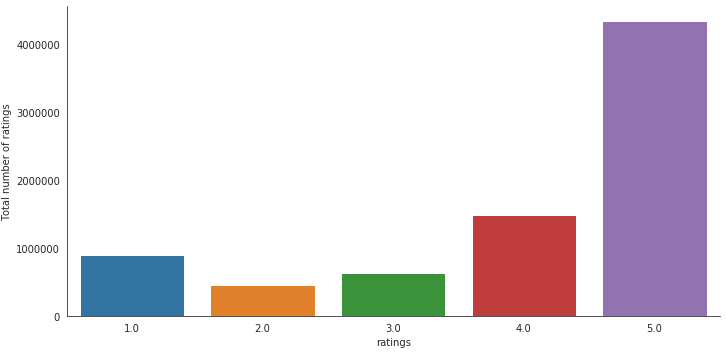

In [12]:
# Plot the ratings
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=prodData, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

#### We can see that 75% of all ratings in the data are 4 to 5 , and very few ratings are 1 or 2, or 3

In [13]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', prodData['userId'].nunique())
print('Number of unique PRODUCTS in Raw data = ', prodData['productId'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique PRODUCTS in Raw data =  476001


In [14]:
print('Highest number of ratings for a Product = ', prodData.groupby('productId')['ratings'].count().max())

Highest number of ratings for a Product =  18244


In [15]:
print('Highest number of ratings given by a User = ', prodData.groupby('userId')['ratings'].count().max())

Highest number of ratings given by a User =  520


In [16]:
# Tried to find the intial density, but system ran out of memory.

In [17]:
# Top 10 users based on rating
most_rated = prodData.groupby('userId').size().sort_values(ascending=False)[:10]
most_rated

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

In [18]:
# Top 10 products based on rating
most_rated = prodData.groupby('productId').size().sort_values(ascending=False)[:10]
most_rated

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
dtype: int64

### 2. Take a subset of the dataset to make it less sparse/ denser. 

In [19]:
min_product_ratings = 50
filter_Product = prodData['productId'].value_counts() > min_product_ratings
filter_Product = filter_Product[filter_Product].index.tolist()

min_user_ratings = 50
filter_users = prodData['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

prodData_new = prodData[(prodData['productId'].isin(filter_Product)) & (prodData['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(prodData.shape))
print('The new data frame shape:\t{}'.format(prodData_new.shape))

The original data frame shape:	(7824481, 3)
The new data frame shape:	(76359, 3)


In [20]:
print('Number of total ratings (50+ ratings on items and Users) =', len(prodData_new))
print('Number of unique USERS in final data = ', prodData_new['userId'].nunique())
print('Number of unique PRODUCTS in final data = ', prodData_new['productId'].nunique())

Number of total ratings (50+ ratings on items and Users) = 76359
Number of unique USERS in final data =  1466
Number of unique PRODUCTS in final data =  16555


In [21]:
#Calculate the density of the rating matrix

In [22]:
final_ratings_matrix = prodData_new.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
print('Shape of Final Ratings Matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('Number of Ratings given = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('Number of ratings possible = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('Density of ratings: {:4.2f}%'.format(density))

Shape of Final Ratings Matrix:  (1466, 16555)
Number of Ratings given =  76359
Number of ratings possible =  24269630
Density of ratings: 0.31%


In [23]:
final_ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

userId,A100UD67AHFODS,A100WO06OQR8BQ,A105S56ODHGJEK,A105TOJ6LTVMBG,A10AFVU66A79Y1,A10H24TDLK2VDP,A10NMELR4KX0J6,A10O7THJ2O20AG,A10PEXB6XAQ5XF,A10X9ME6R66JDX,...,AYOTEJ617O60K,AYP0YPLSP9ISM,AZ515FFZ7I2P7,AZ8XSDMIX04VJ,AZAC8O310IK4E,AZBXKUH4AIW3X,AZCE11PSTCH1L,AZMY6E8B52L2T,AZNUHQSHZHSUE,AZOK5STV85FBJ
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400501776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1400532620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Split the data randomly into train and test dataset.

In [25]:
#Split the data randomnly into test and train datasets
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(prodData_new, test_size = 0.3, random_state=0)
train_data.shape

(53451, 3)

In [26]:
train_data.head()

,userId,productId,ratings
2817357,A2HNH4PKE5DPSI,B002RWJHBM,5.0
2355056,ABSYIF0ONC2AF,B001UI2FPE,5.0
3175398,AKSQNMIKOU01H,B0039VYN1Y,5.0
811945,A2GMZZ6TDYOHY7,B000CRFOMK,5.0
6113053,A3R19YKNL641X3,B0088PPFP4,4.0


In [27]:
test_data.shape

(22908, 3)

In [28]:
test_data.head()

,userId,productId,ratings
1134406,A3TBMGNSEQBWIL,B000LRMS66,5.0
1187281,A12DQZKRKTNF5E,B000MYPPPE,4.0
4693747,A38RMU1Y5TDP9,B0054L8N7M,5.0
3978248,A2Y3WWPUKIJ59I,B004A7ZEI2,4.0
4024423,A25C2M3QF9G7OQ,B004CLYEDC,4.0


### 4. Build Popularity Recommender model. 

In [29]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

,productId,score
0,0972683275,2
1,1400501466,4
2,1400501520,1
3,1400501776,1
4,1400532620,2


In [30]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,Rank
11896,B0088CJT4U,134,1.0
7316,B003ES5ZUU,120,2.0
2835,B000N99BBC,115,3.0
11792,B00829TIEK,101,4.0
12008,B008DWCRQW,100,5.0


In [31]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [32]:
find_recom = [234, 252, 468, 814, 46, 624, 603, 916, 66, 819]   # This list of 10 users is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 234

       userId   productId  score  Rank
11896     234  B0088CJT4U    134   1.0
7316      234  B003ES5ZUU    120   2.0
2835      234  B000N99BBC    115   3.0
11792     234  B00829TIEK    101   4.0
12008     234  B008DWCRQW    100   5.0


Here is the recommendation for the userId: 252

       userId   productId  score  Rank
11896     252  B0088CJT4U    134   1.0
7316      252  B003ES5ZUU    120   2.0
2835      252  B000N99BBC    115   3.0
11792     252  B00829TIEK    101   4.0
12008     252  B008DWCRQW    100   5.0


Here is the recommendation for the userId: 468

       userId   productId  score  Rank
11896     468  B0088CJT4U    134   1.0
7316      468  B003ES5ZUU    120   2.0
2835      468  B000N99BBC    115   3.0
11792     468  B00829TIEK    101   4.0
12008     468  B008DWCRQW    100   5.0


Here is the recommendation for the userId: 814

       userId   productId  score  Rank
11896     814  B0088CJT4U    134   1.0
7316      814  B003ES5

#### Since this is a popularity-based recommender model, recommendations remain the same for all users

#### We predict the products based on the popularity. It is not personalized to particular user

### 5. Build Collaborative Filtering model. 

#### Model-based Collaborative Filtering: Singular Value Decomposition (SVD)

In [33]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,userId,productId,ratings
0,2817357,A2HNH4PKE5DPSI,B002RWJHBM,5.0
1,2355056,ABSYIF0ONC2AF,B001UI2FPE,5.0
2,3175398,AKSQNMIKOU01H,B0039VYN1Y,5.0
3,811945,A2GMZZ6TDYOHY7,B000CRFOMK,5.0
4,6113053,A3R19YKNL641X3,B0088PPFP4,4.0


In [34]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.shape
pivot_df.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [36]:
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [38]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
0,-0.005333,-0.000056,0.002145,0.008884,0.002380,0.014246,0.002184,0.002304,0.003212,0.003255,...,0.000331,0.444215,0.029118,0.046789,0.009622,0.037703,-0.017692,0.068980,0.001545,0.414262
1,0.035619,0.006412,-0.005496,0.026103,0.001517,0.011887,-0.004438,0.012792,0.004579,0.000457,...,-0.000181,-0.024758,0.011408,0.007143,0.030499,0.229293,0.052663,-0.004679,0.014668,0.067420
2,0.015730,0.006647,-0.000879,0.003758,0.003407,-0.006486,-0.000578,0.010783,-0.001580,-0.002130,...,0.000071,-0.032126,0.002601,0.008060,0.016936,0.239959,0.065930,-0.006151,0.003905,0.044298
3,0.007307,0.002516,0.001505,0.000959,-0.000055,0.010070,0.001362,-0.000514,0.007152,0.002350,...,0.000024,0.021853,-0.002618,0.014189,0.007148,-0.012913,0.009194,0.003306,0.000370,0.025694
4,0.009397,0.004397,-0.000179,0.007017,0.001495,0.001929,0.000019,0.007630,-0.000102,-0.000589,...,-0.000046,0.022931,-0.002801,0.001330,0.014300,0.115031,0.028733,-0.002689,0.004801,0.083633


In [39]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [40]:
#Enter 'userID' and 'num_recommendations' for the user 
find_recom_SVD = [234]   
# This list is same as in popularity recommendation
num_recommendations = 5

In [41]:
for i in find_recom_SVD:
    print(recommend_items(i, pivot_df, preds_df, num_recommendations))    
    print("\n") 


Below are the recommended items for user(user_id = 234):

                   user_ratings  user_predictions
Recommended Items                                
B005FYNSPK                  0.0          1.014690
B001TH7GUU                  0.0          0.841903
B009SYZ8OC                  0.0          0.823757
B002V88HFE                  0.0          0.677442
B000067RT6                  0.0          0.665930
None




#### This is a unique set of recommendations for the user based on the users habits. 

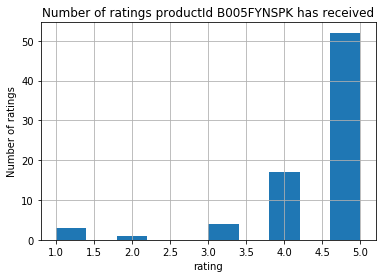

In [42]:
prodData_new.loc[prodData_new['productId'] == 'B005FYNSPK']['ratings'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings productId B005FYNSPK has received')
plt.show()

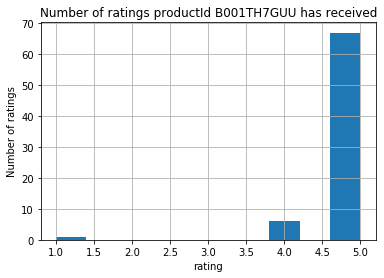

In [43]:
prodData_new.loc[prodData_new['productId'] == 'B001TH7GUU']['ratings'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings productId B001TH7GUU has received')
plt.show()

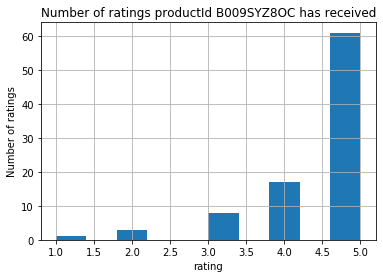

In [44]:
prodData_new.loc[prodData_new['productId'] == 'B009SYZ8OC']['ratings'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings productId B009SYZ8OC has received')
plt.show()

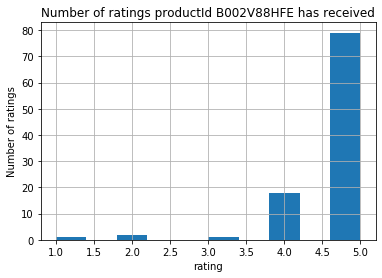

In [45]:
prodData_new.loc[prodData_new['productId'] == 'B002V88HFE']['ratings'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings productId B002V88HFE has received')
plt.show()

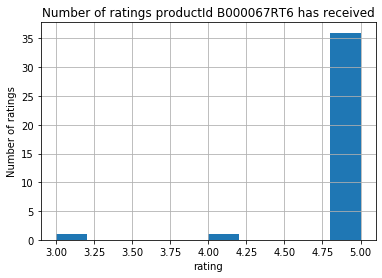

In [46]:
prodData_new.loc[prodData_new['productId'] == 'B000067RT6']['ratings'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings productId B000067RT6 has received')
plt.show()

### 6. Evaluate both the models. 

In [47]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
0972683275    0.010232
1400501466    0.010232
1400501520    0.003411
1400501776    0.006139
1400532620    0.004093
dtype: float64

In [49]:
# Predicted ratings 
preds_df.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,3744295508,...,B00JTI4X3E,B00JX1ZS5O,B00K0OBEE2,B00K4VQZCM,B00K7O2DJU,B00K91DB7Y,B00KFAGCUM,B00KINSDK8,B00KWHMR6G,B00L3YHF6O
0,-0.005333,-0.000056,0.002145,0.008884,0.002380,0.014246,0.002184,0.002304,0.003212,0.003255,...,0.000331,0.444215,0.029118,0.046789,0.009622,0.037703,-0.017692,0.068980,0.001545,0.414262
1,0.035619,0.006412,-0.005496,0.026103,0.001517,0.011887,-0.004438,0.012792,0.004579,0.000457,...,-0.000181,-0.024758,0.011408,0.007143,0.030499,0.229293,0.052663,-0.004679,0.014668,0.067420
2,0.015730,0.006647,-0.000879,0.003758,0.003407,-0.006486,-0.000578,0.010783,-0.001580,-0.002130,...,0.000071,-0.032126,0.002601,0.008060,0.016936,0.239959,0.065930,-0.006151,0.003905,0.044298
3,0.007307,0.002516,0.001505,0.000959,-0.000055,0.010070,0.001362,-0.000514,0.007152,0.002350,...,0.000024,0.021853,-0.002618,0.014189,0.007148,-0.012913,0.009194,0.003306,0.000370,0.025694
4,0.009397,0.004397,-0.000179,0.007017,0.001495,0.001929,0.000019,0.007630,-0.000102,-0.000589,...,-0.000046,0.022931,-0.002801,0.001330,0.014300,0.115031,0.028733,-0.002689,0.004801,0.083633


In [50]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
0972683275    0.009521
1400501466    0.004162
1400501520    0.001922
1400501776    0.004723
1400532620    0.001007
dtype: float64

In [51]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(16555, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0972683275,0.010232,0.009521,0
1400501466,0.010232,0.004162,1
1400501520,0.003411,0.001922,2
1400501776,0.006139,0.004723,3
1400532620,0.004093,0.001007,4


In [52]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00456 



#### The Root Mean squared Error of the SVD model is very low at .00456. 

#### THis means that the model was able to predict the ratings very accurately.

### 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products. 

In [54]:
find_recom = [234, 252, 468, 814, 46, 624, 603, 916, 66, 819, 326, 816]   
# This list is the same as the one used for popularity based recommendation 
num_recommendations = 5
for i in find_recom:
    print(recommend_items(i, pivot_df, preds_df, num_recommendations))  
    print("\n") 


Below are the recommended items for user(user_id = 234):

                   user_ratings  user_predictions
Recommended Items                                
B005FYNSPK                  0.0          1.014690
B001TH7GUU                  0.0          0.841903
B009SYZ8OC                  0.0          0.823757
B002V88HFE                  0.0          0.677442
B000067RT6                  0.0          0.665930
None



Below are the recommended items for user(user_id = 252):

                   user_ratings  user_predictions
Recommended Items                                
B00829TIEK                  0.0          1.075859
B0088CJT4U                  0.0          0.923044
B002V88HFE                  0.0          0.751627
B000QUUFRW                  0.0          0.648917
B00007E7JU                  0.0          0.609905
None



Below are the recommended items for user(user_id = 468):

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJT

### 8. Description of criterion 

#### Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of  the user and it is not dependent on any additional information.

#### The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be  not suitable to the user.

#### In our analysis, for users 234, 252, 468, 814, 46, 624, 603, 916, 66, 819, 326, 816, the Popularity based recommender recommended the same set of 5 products but the Collaborative Filtering based model has recommended entire different list based on the user past rating history